In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from collections import defaultdict

In [2]:
df = pd.read_csv("../data/dataset_tickets_timeseries/all_tickets.tsv", sep="\t")
df["date"] = pd.to_datetime(df.date, unit="ms")
tree = pd.read_csv(
    "../data/dataset_tickets_timeseries/tree_queue.tsv",
    sep="\t",
    converters={"childrenIds": literal_eval},
)

In [3]:
df.head()

,date,queueId,new_t
0,2019-07-31 01:11:04.441,100366,103176935
1,2019-07-31 01:11:10.422,100366,103176934
2,2019-07-31 01:11:27.019,71,103176923
3,2019-07-31 01:13:08.196,4237,103176897
4,2019-07-31 01:13:14.788,4237,103176942


In [4]:
tree.head()

,parentQueueId,childrenIds
0,2010,"[2330, 2010]"
1,1571,"[3085, 1571]"
2,100153,"[3546, 100153, 2732, 1162, 100113, 2980, 3810,..."
3,2538,"[3252, 2583, 2538]"
4,100192,"[100193, 100192]"


In [5]:
tree[~tree.apply(lambda x: x["parentQueueId"] in x["childrenIds"], axis=1)].shape

(4, 2)

троеточие в конце парсится как Ellipsis, мы его уберем, но надо посмотреть, сколько мы потеряли

In [6]:
tree[~tree.apply(lambda x: x["parentQueueId"] in x["childrenIds"], axis=1)].iloc[0, 1][
    -3:
]

[2207, 2059, Ellipsis]

In [7]:
def process_children_ids(row):
    children = row["childrenIds"]
    if isinstance(children, list):
        children = [int(x) for x in children if isinstance(x, int)]
        if row["parentQueueId"] not in children:
            children.append(row["parentQueueId"])
    return children


tree["childrenIds"] = tree.apply(process_children_ids, axis=1)

### Может ли очередь быть просто дочерней, но не в `parentQueueId`?

In [8]:
all_queues = set(df.queueId.unique())
len(all_queues)

570

In [9]:
tree.shape

(337, 2)

Да, может, не все очереди в `parentQueueId` попадают

### Сколько выпавших очередей, потенциально из-за `...`

In [10]:
all_queues_in_hierarchy = set()


def update_queues_hierarchy(row):
    all_queues_in_hierarchy.add(row["parentQueueId"])
    for children in row["childrenIds"]:
        all_queues_in_hierarchy.add(children)


tree.apply(update_queues_hierarchy, axis=1)
None

In [11]:
len(all_queues_in_hierarchy)

1651

55 выпавших очередей

In [12]:
queues_not_in_hierarchy = all_queues - all_queues_in_hierarchy
len(queues_not_in_hierarchy)

55

In [13]:
print(queues_not_in_hierarchy)

{100353, 100354, 3, 100355, 100356, 4, 100357, 100359, 100361, 100362, 100360, 100364, 100365, 100366, 100363, 24, 3866, 4512, 100399, 100400, 100402, 100407, 100408, 100409, 100410, 100411, 100413, 100414, 100415, 100416, 4162, 100418, 100420, 100421, 100427, 100429, 100430, 100440, 3685, 100331, 100332, 100334, 100335, 100336, 100337, 2802, 100339, 100340, 100342, 100344, 100345, 100348, 100349, 100350, 2943}


### Насколько потерянные очереди большие

In [14]:
df_extra_queue = df[df.queueId.isin(queues_not_in_hierarchy)]
df_extra_queue.value_counts("queueId")[:10]

queueId
4512      24057
100335    11830
24         9386
100399     5951
100336     5747
100366     4569
100349     3442
100334     1699
100331      559
100429      546
Name: count, dtype: int64

In [15]:
print(f"extra rows: {df_extra_queue.shape[0] / df.shape[0]:.2%}")

extra rows: 7.47%


топ очередей в целом, видна выпавшая очередь `4512`

In [16]:
df.value_counts("queueId")[:10]

queueId
4212    138604
4237    137975
4462     78150
4472     53902
4457     29814
4322     25400
4512     24057
4397     19081
2844     18278
4442     18254
Name: count, dtype: int64

### Анализ иерархии очередей

In [17]:
def get_depth(queue_id, visited=None):
    if visited is None:
        visited = set()
    if queue_id in visited:
        return 0
    visited.add(queue_id)
    children = tree[tree["parentQueueId"] == queue_id]["childrenIds"].values
    if len(children) == 0:
        return 1
    return 1 + max(get_depth(child, visited.copy()) for child in children[0])


tree["depth"] = tree["parentQueueId"].apply(get_depth)

In [18]:
tree["depth"].describe().round(3)

count    337.000
mean       2.371
std        0.784
min        1.000
25%        2.000
50%        2.000
75%        2.000
max        6.000
Name: depth, dtype: float64

In [19]:
tree[tree["depth"] == 1]

,parentQueueId,childrenIds,depth
16,100281,[100281],1
306,100307,[100307],1


In [20]:
tree[tree["depth"] == 2].head()

,parentQueueId,childrenIds,depth
0,2010,"[2330, 2010]",2
1,1571,"[3085, 1571]",2
2,100153,"[3546, 100153, 2732, 1162, 100113, 2980, 3810,...",2
3,2538,"[3252, 2583, 2538]",2
4,100192,"[100193, 100192]",2


In [21]:
tree[tree["depth"] == 6]

,parentQueueId,childrenIds,depth
25,2034,"[2713, 2100, 2327, 2326, 2329, 2328, 2079, 266...",6
35,2870,"[211, 2653, 2651, 2650, 2654, 3048, 3047, 3556...",6
150,742,"[3715, 2964, 3496, 1262, 2840, 26, 691, 1142, ...",6
176,2299,"[2717, 2846, 2842, 2843, 3410, 2320, 2480, 248...",6


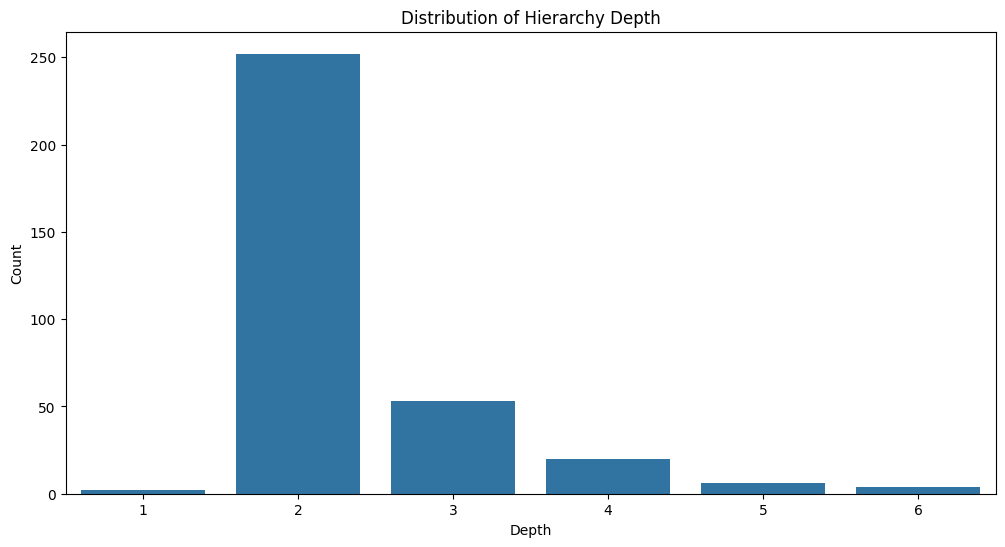

In [22]:
plt.figure(figsize=(12, 6))
depth_counts = tree["depth"].value_counts().sort_index()
sns.barplot(x=depth_counts.index, y=depth_counts.values)
plt.title("Distribution of Hierarchy Depth")
plt.xlabel("Depth")
plt.ylabel("Count")
plt.show()

In [23]:
def get_all_children(queue_id, df, queue_to_all_children):
    if queue_id in queue_to_all_children:
        return queue_to_all_children[queue_id]

    row = df[df["parentQueueId"] == queue_id]
    if row.empty:
        queue_to_all_children[queue_id] = set([queue_id])
        return set([queue_id])

    children = set(row["childrenIds"].iloc[0])
    all_children = children.copy()
    all_children.add(queue_id)

    for child in children:
        if isinstance(child, int) and child != queue_id:
            all_children.update(get_all_children(child, df, queue_to_all_children))

    queue_to_all_children[queue_id] = all_children
    return all_children


queue_to_all_children = {}

all_queues = set(tree["parentQueueId"].unique())
for children_list in tree["childrenIds"]:
    all_queues.update(children_list)

for queue_id in all_queues:
    get_all_children(queue_id, tree, queue_to_all_children)

In [24]:
total_counts = defaultdict(int)

for queue_id, children in queue_to_all_children.items():
    count = df[df["queueId"].isin(children)]["new_t"].count()
    total_counts[queue_id] = count

sorted_counts = sorted(total_counts.items(), key=lambda x: x[1], reverse=True)

top_10_queues = sorted_counts[:10]

for queue_id, count in top_10_queues:
    print(f"Queue {queue_id}: {count}")

Queue 4212: 303967
Queue 502: 149343
Queue 4237: 137975
Queue 10: 91939
Queue 4462: 78150
Queue 4447: 69420
Queue 4472: 53902
Queue 742: 49213
Queue 72: 42545
Queue 4397: 41487


### Есть дубликаты (обозначают новое сообщение в тикете)

есть дубликаты по номеру тикета (50%+), но нет по номеру тикета+дата

In [25]:
df.duplicated(subset=["new_t"]).sum(), df.duplicated(subset=["new_t", "date"]).sum()

(547292, 0)

In [26]:
df.describe()

,date,queueId,new_t
count,993863,993863.000000,9.938630e+05
mean,2019-07-16 18:02:12.875318272,14692.285437,1.029167e+08
min,2019-07-01 00:00:49.870000,1.000000,1.553664e+07
25%,2019-07-08 20:43:11.639000064,4212.000000,1.028431e+08
50%,2019-07-16 19:36:18.728000,4237.000000,1.029575e+08
75%,2019-07-24 16:47:05.800499968,4462.000000,1.030737e+08
max,2019-07-31 23:59:17.138000,100440.000000,1.031944e+08
std,NaN,30444.258060,1.295140e+06


### Как часто повторяются тикеты

In [27]:
ticket_repetitions = df.groupby("new_t").size().value_counts().sort_index()
ticket_repetitions[:10]

1      15717
2     372167
3      33302
4      13091
5       5543
6       2761
7       1489
8        818
9        482
10       344
Name: count, dtype: int64

In [28]:
ticket_repetitions.nlargest(5)

2    372167
3     33302
1     15717
4     13091
5      5543
Name: count, dtype: int64

In [29]:
ticket_duration = df.groupby("new_t")["date"].agg(["min", "max"])
ticket_duration["duration"] = ticket_duration["max"] - ticket_duration["min"]

ticket_duration["duration"].describe()

count                       446571
mean     0 days 11:50:28.520428435
std      2 days 06:38:51.893084397
min                0 days 00:00:00
25%         0 days 00:05:10.436500
50%         0 days 00:08:44.622000
75%         0 days 00:14:54.692500
max        30 days 15:03:06.190000
Name: duration, dtype: object

In [30]:
print(f"Median ticket duration: {ticket_duration['duration'].median()}")

Median ticket duration: 0 days 00:08:44.622000


Чаще всего тикет повторяется два раза, медианное время между максимальным повтором около 9 минут.

### Ресемплинг

In [31]:
df_d = df.set_index("date")

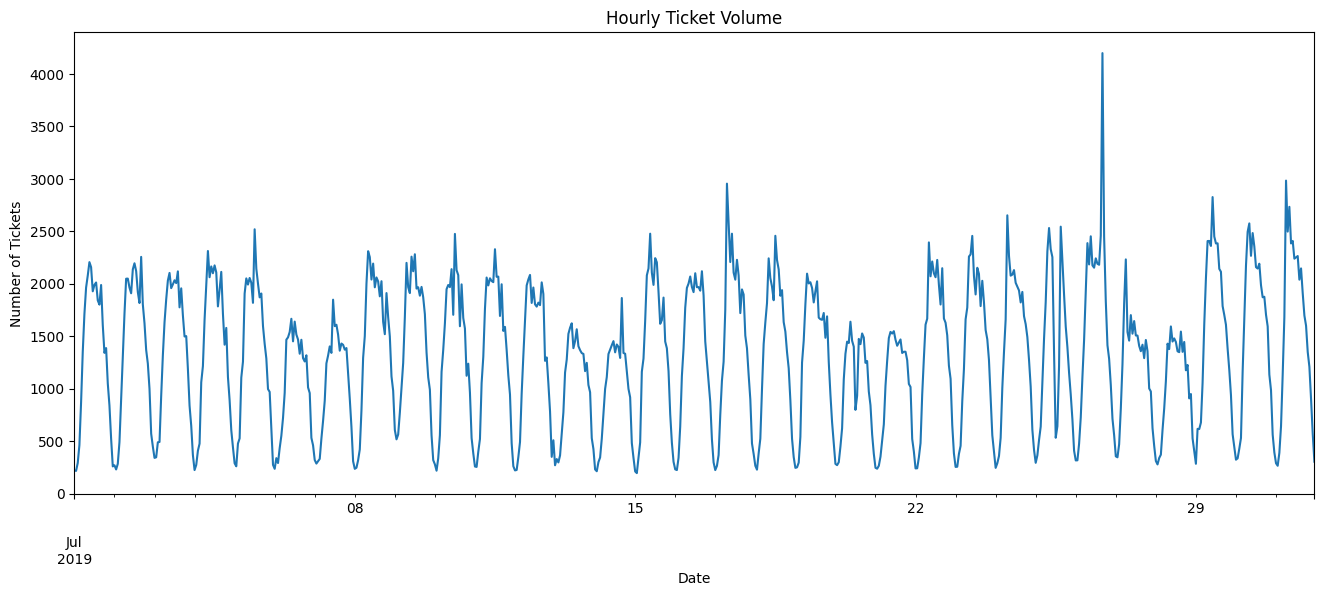

In [32]:
hourly_tickets = df_d.resample("1h").size()

plt.figure(figsize=(16, 6))
hourly_tickets.plot()
plt.title("Hourly Ticket Volume")
plt.xlabel("Date")
plt.ylabel("Number of Tickets")
plt.show()

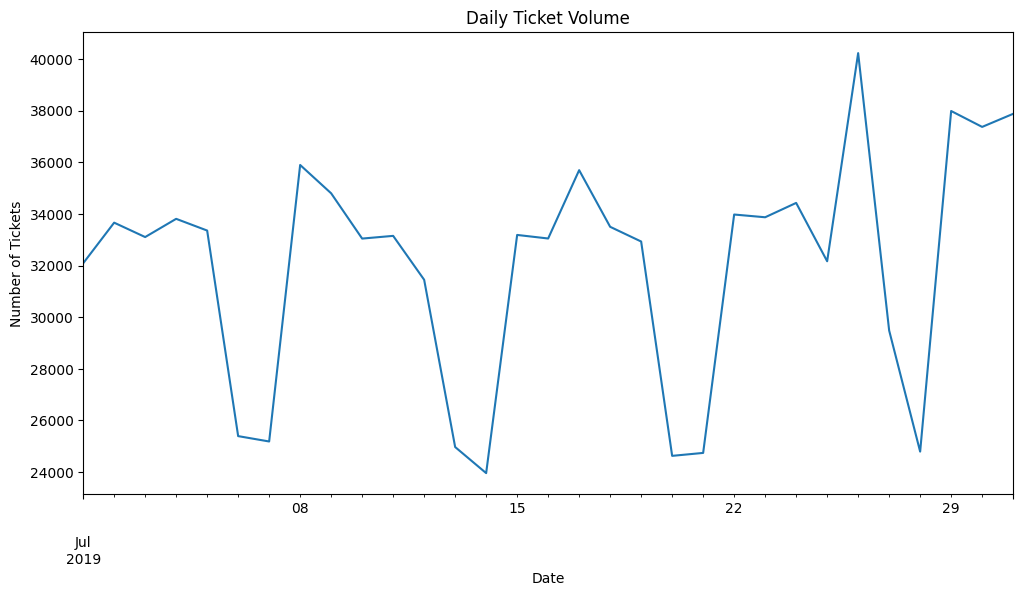

In [33]:
daily_tickets = df_d.resample("D").size()

plt.figure(figsize=(12, 6))
daily_tickets.plot()
plt.title("Daily Ticket Volume")
plt.xlabel("Date")
plt.ylabel("Number of Tickets")
plt.show()

In [34]:
df_d["day_of_week"] = df_d.index.dayofweek
df_d["month"] = df_d.index.month
df_d["year"] = df_d.index.year
forecast_data = (
    df_d.groupby([df_d.index.date, "queueId"])
    .agg({"new_t": "count", "day_of_week": "first", "month": "first", "year": "first"})
    .reset_index()
)

forecast_data.rename(columns={"new_t": "ticket_count"}, inplace=True)

forecast_data.head()

,level_0,queueId,ticket_count,day_of_week,month,year
0,2019-07-01,1,63,0,7,2019
1,2019-07-01,7,55,0,7,2019
2,2019-07-01,10,15,0,7,2019
3,2019-07-01,13,4,0,7,2019
4,2019-07-01,14,7,0,7,2019
